In [91]:
# In[1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

In [92]:
ls

 Volume in drive D is New Volume
 Volume Serial Number is E4F5-C450

 Directory of d:\FinAI2\FinAI\backend\model

25-03-2025  19:00    <DIR>          .
24-03-2025  20:00    <DIR>          ..
25-03-2025  17:01    <DIR>          .ipynb_checkpoints
25-03-2025  18:34            23,019 category_forecast.csv
25-03-2025  19:34           206,868 DL_Model_Expenses.ipynb
24-03-2025  19:56            30,818 expenses.csv
25-03-2025  14:09            29,712 expenses2.csv
25-03-2025  18:53             8,519 final_forecast.csv
25-03-2025  18:46    <DIR>          saved_arima_models
               5 File(s)        298,936 bytes
               4 Dir(s)  183,065,026,560 bytes free


In [93]:
df = pd.read_csv(
    'expenses2.csv',  # change to your actual file path
    usecols=['date', 'category', 'expense_amt_categorized']
)

# Parse the 'date' column (format is YYYY-MM-DD)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.groupby(['date', 'category'], as_index=False)['expense_amt_categorized'].sum()

print(df.head())
print(df.shape)

        date       category  expense_amt_categorized
0 2024-10-23      Education                      494
1 2024-10-23           Rent                      173
2 2024-10-23        Savings                      433
3 2024-10-24      Education                      298
4 2024-10-24  Entertainment                      442
(456, 3)


In [94]:
true_last_date = df['date'].max()

print("Last available date in the dataset:", true_last_date)

Last available date in the dataset: 2025-03-23 00:00:00


In [95]:
import numpy as np
import pandas as pd
import itertools
import joblib
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

def find_best_arima_order(ts):
    """
    Find the best ARIMA parameters using grid search and AIC
    
    Args:
    ts (pd.Series): Time series data
    
    Returns:
    tuple: Best (p,d,q) order
    """
    # Define parameter ranges
    p = range(0, 3)  # AR terms
    d = range(0, 2)  # Differencing
    q = range(0, 3)  # MA terms
    
    # Generate all possible parameter combinations
    pdq = list(itertools.product(p, d, q))
    
    # Find best model based on lowest AIC
    best_aic = np.inf
    best_order = None
    
    print(f"Searching for best ARIMA order. Series length: {len(ts)}")
    
    for param in pdq:
        try:
            # Print each parameter combination being tried
            print(f"Trying ARIMA order: {param}")
            
            model = ARIMA(ts, order=param)
            results = model.fit()
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                print(f"New best order: {best_order}, AIC: {best_aic}")
        except Exception as e:
            print(f"Error fitting ARIMA{param}: {e}")
            continue
    
    print(f"Best ARIMA order found: {best_order}")
    return best_order

def rolling_forecast_validation(ts, initial_train_size=90, horizon=30):
    """Performs rolling forecast validation on time series data."""
    tscv = TimeSeriesSplit(n_splits=5)
    errors = []
    
    print(f"Starting rolling forecast validation. Total series length: {len(ts)}")
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(ts), 1):
        train, test = ts.iloc[train_idx], ts.iloc[test_idx]
        
        print(f"\nFold {fold}:")
        print(f"Train size: {len(train)}, Test size: {len(test)}")
        
        try:
            # Find best order for each fold
            best_order = find_best_arima_order(train)
            
            # Fit ARIMA model
            model = ARIMA(train, order=best_order).fit()
            
            # Forecast
            forecast = model.forecast(steps=len(test))
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(test, forecast))
            errors.append(rmse)
            
            print(f"Fold {fold} RMSE: {rmse}")
        except Exception as e:
            print(f"ARIMA failed on validation fold {fold}. Reason: {e}")
    
    avg_error = np.mean(errors) if errors else None
    print(f"\nAverage RMSE across folds: {avg_error}")
    return avg_error

def perform_category_forecasting(df):
    """
    Perform forecasting for each category
    
    Args:
    df (pd.DataFrame): Input dataframe
    
    Returns:
    pd.DataFrame: Forecasted expenses
    """
    # Create a directory to save models if it doesn't exist
    os.makedirs('saved_arima_models', exist_ok=True)
    
    # Validate input DataFrame
    if df is None or df.empty:
        print("Error: Input DataFrame is None or empty")
        return None
    
    # Find the last available date
    true_last_date = df['date'].max()
    
    # Get unique categories
    all_categories = df["category"].unique()
    
    # List to store forecasts
    forecasts_list = []
    
    # Dictionary to store category errors and models
    category_errors = {}
    category_models = {}
    
    for cat in all_categories:
        # Filter and prepare data for the category
        df_cat = df[df["category"] == cat].copy()
        
        df_cat.set_index("date", inplace=True)
        df_cat = df_cat.resample("D").sum().fillna(0)  # Ensure daily data
        
        # Ensure time series is not empty
        if df_cat.empty:
            print(f"Warning: No data for category {cat}")
            continue
        
        ts = df_cat["expense_amt_categorized"]
        
        try:
            # Perform rolling forecast validation
            rmse_score = rolling_forecast_validation(ts)
            category_errors[cat] = rmse_score
            
            # Find best ARIMA order
            best_order = find_best_arima_order(ts)
            
            # Fit ARIMA model
            model = ARIMA(ts, order=best_order).fit()
            
            # Save the model
            model_filename = f'saved_arima_models/{cat}_arima_model.pkl'
            joblib.dump(model, model_filename)
            print(f"Saved ARIMA model for {cat} to {model_filename}")
            
            # Store model details
            category_models[cat] = {
                'model_path': model_filename,
                'order': best_order,
                'rmse': rmse_score
            }
            
            # Generate future dates
            future_dates = pd.date_range(start=true_last_date + pd.Timedelta(days=1), periods=30, freq='D')
            
            # Forecast
            forecast = model.forecast(steps=30)
            
            # Prepare forecast dataframe
            forecast_df = pd.DataFrame({
                'date': future_dates,
                'predicted_expense': forecast,
                'category': cat
            })
            
            # Cap predictions based on past maximum spending per category
            max_past_spending = ts.max()
            forecast_df["predicted_expense"] = np.minimum(forecast_df["predicted_expense"], max_past_spending)
            
            forecasts_list.append(forecast_df)
        
        except Exception as e:
            print(f"ARIMA failed for category {cat}. Detailed Error: {e}")
            import traceback
            traceback.print_exc()

    # Save category models metadata
    joblib.dump(category_models, 'saved_arima_models/category_models_metadata.pkl')
    
    if forecasts_list:
        final_forecast = pd.concat(forecasts_list, ignore_index=True)
        final_forecast.sort_values(by=['date', 'category'], inplace=True)
        
        print("\n--- Final Forecast ---")
        print("Next 30 Days Predicted Expenses by Category:")
        print(final_forecast)
        
        return final_forecast
    else:
        print("No forecasts were generated.")
        return None

# Run the forecasting
final_forecast = perform_category_forecasting(df)

# Save final forecast to CSV
final_forecast.to_csv('final_forecast.csv', index=False)

# Verify the file was saved
print("Forecast saved to final_forecast.csv")

Starting rolling forecast validation. Total series length: 151

Fold 1:
Train size: 26, Test size: 25
Searching for best ARIMA order. Series length: 26
Trying ARIMA order: (0, 0, 0)
New best order: (0, 0, 0), AIC: 343.67976183908394
Trying ARIMA order: (0, 0, 1)
New best order: (0, 0, 1), AIC: 342.88997207041297
Trying ARIMA order: (0, 0, 2)
Trying ARIMA order: (0, 1, 0)
New best order: (0, 1, 0), AIC: 332.2595280452013
Trying ARIMA order: (0, 1, 1)
New best order: (0, 1, 1), AIC: 329.44698642243156
Trying ARIMA order: (0, 1, 2)
Trying ARIMA order: (1, 0, 0)
Trying ARIMA order: (1, 0, 1)
Trying ARIMA order: (1, 0, 2)
Trying ARIMA order: (1, 1, 0)
Trying ARIMA order: (1, 1, 1)
Trying ARIMA order: (1, 1, 2)
Trying ARIMA order: (2, 0, 0)
Trying ARIMA order: (2, 0, 1)
Trying ARIMA order: (2, 0, 2)
Trying ARIMA order: (2, 1, 0)
Trying ARIMA order: (2, 1, 1)
Trying ARIMA order: (2, 1, 2)
Best ARIMA order found: (0, 1, 1)
Fold 1 RMSE: 213.26999325337647

Fold 2:
Train size: 51, Test size: 25


In [96]:
final_forecast = pd.read_csv('final_forecast.csv')

In [97]:
category_sums = final_forecast.groupby("category")["predicted_expense"].sum()

# Sort in descending order
category_sums_sorted = category_sums.sort_values(ascending=False)

print("\n📊 Category-wise Total Predicted Expense for Next 30 Days (Descending Order):")
print(category_sums_sorted)


📊 Category-wise Total Predicted Expense for Next 30 Days (Descending Order):
category
Food & Drink     10347.363094
Groceries         9971.249505
Rent              8839.786332
Personal          6813.199871
Education         5557.251304
Savings           5426.341725
Entertainment     4036.031246
Name: predicted_expense, dtype: float64


In [98]:
total_predicted_expense = category_sums.sum()

print("\n💰 **Total Predicted Expense for Next 30 Days:**", total_predicted_expense)



💰 **Total Predicted Expense for Next 30 Days:** 50991.223076661045


In [99]:
import pandas as pd
import numpy as np

# Example: Assume final_forecast is your forecast DataFrame with columns: "date", "predicted_expense", "category"
# For demonstration, we'll compute category sums from final_forecast:
category_sums = final_forecast.groupby("category")["predicted_expense"].sum()
print("Original Category Sums (Predicted):")
print(category_sums)

# Total predicted expense across all categories
total_predicted = category_sums.sum()

# User-defined budget, e.g., 40000 (this value can be changed)
user_budget = 40000

# Calculate a scaling factor to reduce the predicted values proportionally
scale_factor = user_budget / total_predicted

# Scale each category's predicted expense
scaled_category_sums = category_sums * scale_factor

# Round each scaled value to the nearest ten (e.g., 4678 becomes 4680)
rounded_category_sums = scaled_category_sums.apply(lambda x: round(x / 10) * 10)

# Check if rounding causes a mismatch from the user budget
difference = user_budget - rounded_category_sums.sum()
print(f"\nBudget difference after initial rounding: {difference}")

# Adjustment: Distribute the remaining difference (in multiples of 10) across categories.
# Here, we compute the residual (scaled - rounded) for each category.
if difference != 0:
    # Calculate residual differences
    remainders = scaled_category_sums - rounded_category_sums
    
    # Determine how many tens to add or remove
    increments = int(round(abs(difference) / 10))
    
    if difference > 0:
        # If the total is below the budget, add tens to categories with the highest positive remainders.
        sorted_cats = remainders.sort_values(ascending=False).index
        for cat in sorted_cats:
            if increments <= 0:
                break
            rounded_category_sums[cat] += 10
            increments -= 1
    elif difference < 0:
        # If the total is above the budget, subtract tens from categories with the lowest (or most negative) residuals.
        sorted_cats = remainders.sort_values(ascending=True).index
        for cat in sorted_cats:
            if increments <= 0:
                break
            # Ensure that we don't subtract below 0.
            if rounded_category_sums[cat] >= 10:
                rounded_category_sums[cat] -= 10
            increments -= 1

# Final adjusted category allocations
print("\nAdjusted Category-wise Budget Allocation (Rounded to Tens):")
print(rounded_category_sums)

# Optional: Verify that the sum equals the user budget.
print("\nTotal Allocated Budget:", rounded_category_sums.sum())


Original Category Sums (Predicted):
category
Education         5557.251304
Entertainment     4036.031246
Food & Drink     10347.363094
Groceries         9971.249505
Personal          6813.199871
Rent              8839.786332
Savings           5426.341725
Name: predicted_expense, dtype: float64

Budget difference after initial rounding: 0

Adjusted Category-wise Budget Allocation (Rounded to Tens):
category
Education        4360
Entertainment    3170
Food & Drink     8120
Groceries        7820
Personal         5340
Rent             6930
Savings          4260
Name: predicted_expense, dtype: int64

Total Allocated Budget: 40000


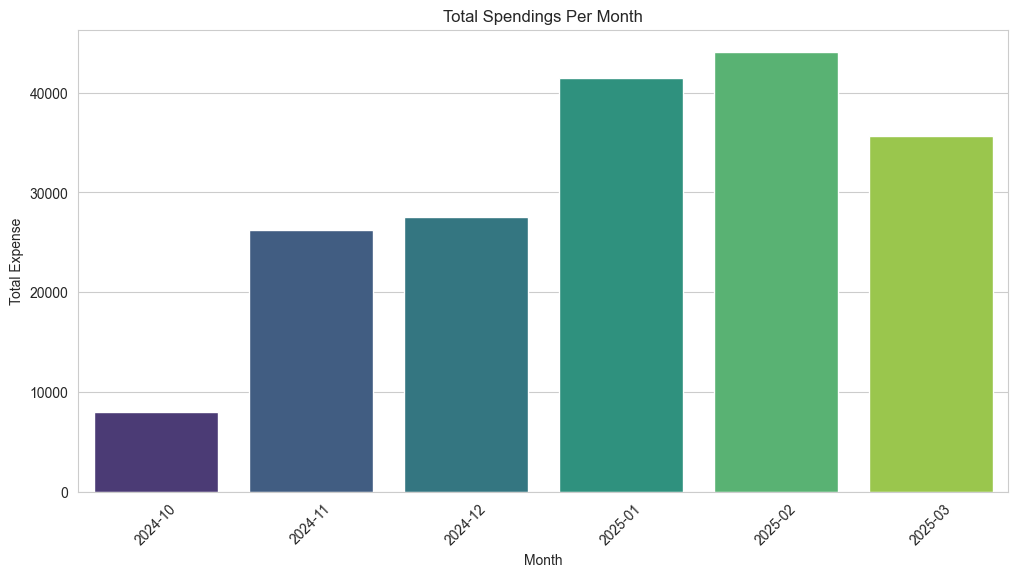

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("expenses2.csv")

# Convert 'date' column to datetime format
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

# Extract year and month for grouping
df["year_month"] = df["date"].dt.to_period("M")

# Aggregate total expenses per month
monthly_expense = df.groupby("year_month")["expense_amt_categorized"].sum().reset_index()

# Convert 'year_month' to string for plotting
monthly_expense["year_month"] = monthly_expense["year_month"].astype(str)

# Set plot style
sns.set_style("whitegrid")

# Plot total expenses per month
plt.figure(figsize=(12, 6))
sns.barplot(
    x="year_month",
    y="expense_amt_categorized",
    data=monthly_expense,
    palette="viridis"
)
plt.xlabel("Month")
plt.ylabel("Total Expense")
plt.title("Total Spendings Per Month")
plt.xticks(rotation=45)
plt.show()


<Figure size 1200x600 with 0 Axes>

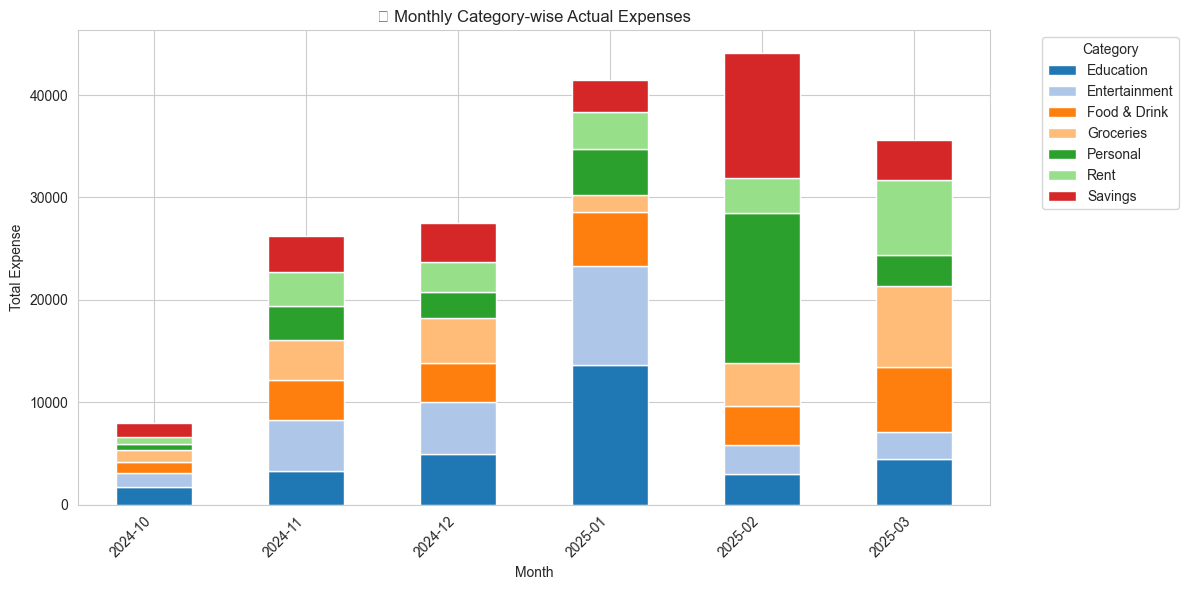


Monthly Category Expenses:
category  Education  Entertainment  Food & Drink  ...  Personal  Rent  Savings
date                                              ...                         
2024-10        1700           1403          1044  ...       501   730     1374
2024-11        3304           4922          3931  ...      3321  3301     3540
2024-12        4957           5069          3857  ...      2482  2997     3827
2025-01       13598           9758          5176  ...      4509  3587     3191
2025-02        2974           2862          3809  ...     14678  3403    12184
2025-03        4448           2658          6332  ...      3036  7316     3972

[6 rows x 7 columns]


In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by month and category, sum the expenses
monthly_category_expense_actual = df.groupby([df['date'].dt.to_period('M'), 'category'])['expense_amt_categorized'].sum().unstack()

# Ensure the index is converted to strings for plotting
monthly_category_expense_actual.index = monthly_category_expense_actual.index.astype(str)

# Generate 18 distinct colors using seaborn color palette
unique_colors = sns.color_palette("tab20", n_colors=len(monthly_category_expense_actual.columns))

# Plot category-wise expenses over months with unique colors
plt.figure(figsize=(12, 6))
monthly_category_expense_actual.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    color=unique_colors
)

plt.title("📊 Monthly Category-wise Actual Expenses")
plt.xlabel("Month")
plt.ylabel("Total Expense")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Optional: Print the monthly category expense data
print("\nMonthly Category Expenses:")
print(monthly_category_expense_actual)

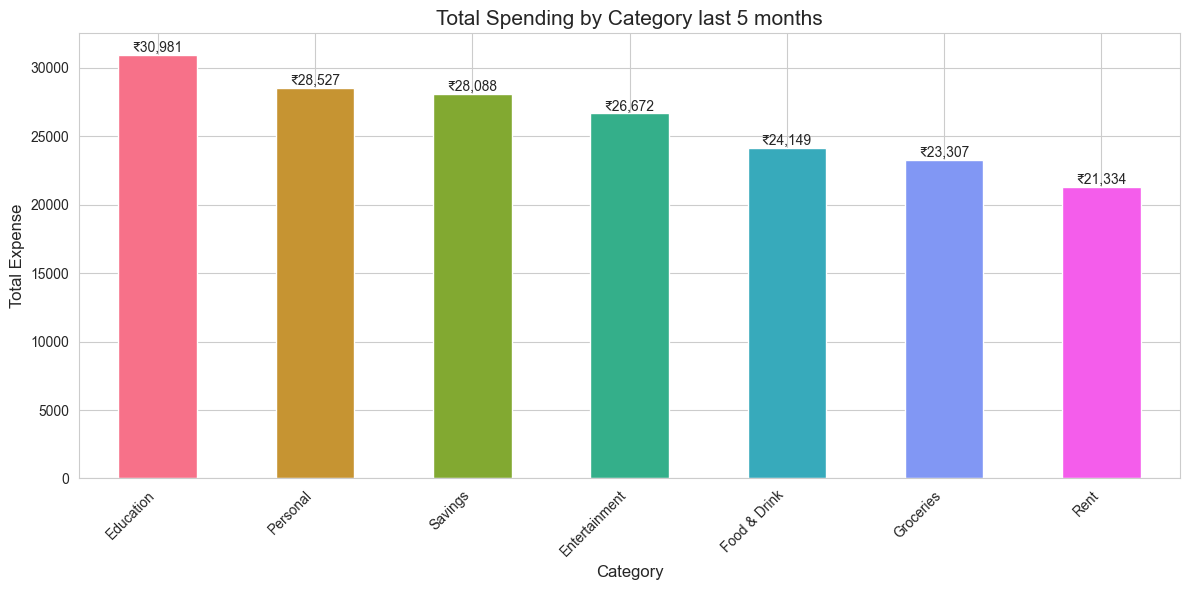


Total Spending by Category:
category
Education        30981
Personal         28527
Savings          28088
Entertainment    26672
Food & Drink     24149
Groceries        23307
Rent             21334
Name: expense_amt_categorized, dtype: int64


In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total spending by category
category_total_spending = df.groupby('category')['expense_amt_categorized'].sum().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
category_total_spending.plot(kind='bar', color=sns.color_palette("husl", len(category_total_spending)))

plt.title('Total Spending by Category last 5 months', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Total Expense', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on top of each bar
for i, v in enumerate(category_total_spending):
    plt.text(i, v, f'₹{v:,.0f}', ha='center', va='bottom')

plt.show()

# Print the total spending for each category
print("\nTotal Spending by Category:")
print(category_total_spending)

In [103]:
# Set pandas display options to show all columns and rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Expand display width
pd.set_option('display.max_rows', None)  # Show all rows

# Print the monthly category expense data
print("\nMonthly Category Expenses:")
print(monthly_category_expense_actual)

# Reset display options if needed
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_rows')


Monthly Category Expenses:
category  Education  Entertainment  Food & Drink  Groceries  Personal  Rent  \
date                                                                          
2024-10        1700           1403          1044       1247       501   730   
2024-11        3304           4922          3931       3958      3321  3301   
2024-12        4957           5069          3857       4359      2482  2997   
2025-01       13598           9758          5176       1672      4509  3587   
2025-02        2974           2862          3809       4191     14678  3403   
2025-03        4448           2658          6332       7880      3036  7316   

category  Savings  
date               
2024-10      1374  
2024-11      3540  
2024-12      3827  
2025-01      3191  
2025-02     12184  
2025-03      3972  
